In [1]:
#pip install snowflake-connector-python

In [2]:
# Cargar dependencias
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd

# Cargar variables de entorno desde .env
load_dotenv()

# Parámetros de conexión con el account identifier correcto
connection_params = {
    'user': 'XxHurtadoxX',
    'password': os.getenv('SNOWFLAKE_PASSWORD'),
    'account': 'PONTQSB-GV54375',
    'database': 'CONTOSO_PRACTICE',
    'schema': 'RETAIL',
    'warehouse': 'COMPUTE_WH'
}

# Establecer conexión
print("Conectando a Snowflake...")
conn = snowflake.connector.connect(**connection_params)
cursor = conn.cursor()
print("✅ Conexión exitosa!")

Conectando a Snowflake...
✅ Conexión exitosa!


In [3]:
# Ejecutar la consulta y cargar en un DataFrame
cursor.execute("""SELECT s.DATEKEY,   
                         s.SALESQUANTITY, 
                         s.TOTALCOST, 
                         s.SALESAMOUNT,
                         st.SELLINGAREASIZE,
                         st.EMPLOYEECOUNT, st.STOREKEY,
                         g.REGIONCOUNTRYNAME, g.STATEPROVINCENAME, g.CITYNAME                      
                  FROM SALES as s
                  LEFT JOIN STORE as st ON s.STOREKEY = st.STOREKEY
                  LEFT JOIN GEOGRAPHY as g ON st.GEOGRAPHYKEY = g.GEOGRAPHYKEY""")

results = cursor.fetchall()

# Obtener los nombres de las columnas
column_names = [desc[0] for desc in cursor.description]

# Crear DataFrame
df = pd.DataFrame(results, columns=column_names)

print(f"✅ Datos cargados: {len(df):,.0f} filas, {len(df.columns)} columnas")
print("\nPrimeras 5 filas:")
df.head()

✅ Datos cargados: 3,189,990 filas, 10 columnas

Primeras 5 filas:


,DATEKEY,SALESQUANTITY,TOTALCOST,SALESAMOUNT,SELLINGAREASIZE,EMPLOYEECOUNT,STOREKEY,REGIONCOUNTRYNAME,STATEPROVINCENAME,CITYNAME
0,2007-11-28,18,550.44,995.834,500,325,199,United States,Maryland,Bethesda
1,2007-11-03,16,1224.48,3557.400,1000,7,306,Germany,Berlin,Berlin
2,2007-12-16,8,1142.00,2071.926,680,15,217,France,Rhone-Alpes,Lyon
3,2009-10-14,10,533.40,1160.000,700,25,32,United States,Colorado,Milliken
4,2008-12-26,8,228.40,425.600,1000,7,306,Germany,Berlin,Berlin


In [4]:
df.groupby('REGIONCOUNTRYNAME')['SALESAMOUNT'].sum().sort_values(ascending=False)

REGIONCOUNTRYNAME
United States      6.588334e+09
China              1.556648e+09
Germany            7.599328e+08
France             6.172725e+08
United Kingdom     2.943247e+08
Canada             2.349746e+08
Japan              2.213601e+08
Germany            1.927290e+08
Australia          1.056094e+08
India              1.049266e+08
Russia             9.492584e+07
Italy              7.348449e+07
Iran               7.058598e+07
Turkmenistan       6.933950e+07
Syria              6.250650e+07
Pakistan           6.057282e+07
South Korea        4.976516e+07
Thailand           4.933075e+07
Bhutan             4.102652e+07
Taiwan             3.516910e+07
Kyrgyzstan         3.512893e+07
Armenia            3.505792e+07
Singapore          3.394309e+07
Romania            2.042405e+07
Portugal           2.029443e+07
Spain              2.022316e+07
Denmark            2.013524e+07
Poland             2.013408e+07
the Netherlands    2.009219e+07
Greece             1.998949e+07
Ireland            1.9

In [5]:
# Ejemplo 1: Análisis de ventas por tienda usando GROUP BY
query_group = """
SELECT st.STOREKEY,
       g.CITYNAME,
       COUNT(s.SALESKEY) as TOTAL_TRANSACTIONS,
       SUM(s.SALESAMOUNT) as TOTAL_REVENUE,
       AVG(s.SALESAMOUNT) as AVG_SALE_AMOUNT,
       MAX(s.SALESAMOUNT) as MAX_SALE
FROM SALES s
LEFT JOIN STORE st ON s.STOREKEY = st.STOREKEY
LEFT JOIN GEOGRAPHY g ON st.GEOGRAPHYKEY = g.GEOGRAPHYKEY
GROUP BY st.STOREKEY, g.CITYNAME
ORDER BY TOTAL_REVENUE DESC
LIMIT 10
"""

print("📊 Análisis de ventas por tienda...")
cursor.execute(query_group)
results_group = cursor.fetchall()
column_names_group = [desc[0] for desc in cursor.description]
df_stores = pd.DataFrame(results_group, columns=column_names_group)

print(f"✅ Datos cargados: {len(df_stores)} tiendas")
df_stores

📊 Análisis de ventas por tienda...
✅ Datos cargados: 10 tiendas


,STOREKEY,CITYNAME,TOTAL_TRANSACTIONS,TOTAL_REVENUE,AVG_SALE_AMOUNT,MAX_SALE
0,200,North Harford,182528,1.010623e+09,5536.808785,408016.020
1,199,Bethesda,222775,9.205601e+08,4132.241309,135297.900
2,307,Beijing,181401,8.320150e+08,4586.606461,162559.492
3,306,Berlin,185243,7.551547e+08,4076.562552,164479.800
4,308,Seattle,133892,5.892160e+08,4400.680867,150719.529
5,310,Beijing,122054,5.281676e+08,4327.327384,128073.750
6,309,Paris,125994,4.898726e+08,3888.063030,157316.970
7,253,Sydney,10257,3.554823e+07,3465.753550,40639.873
8,278,Urumqi,10326,3.544807e+07,3432.894925,54399.830
9,300,Sydney,10266,3.541311e+07,3449.553179,49980.000


In [6]:
# Ejemplo 2: Tiendas con alto rendimiento usando GROUP BY y HAVING
query_having = """
SELECT st.STOREKEY,
       g.CITYNAME,
       g.STATEPROVINCENAME,
       COUNT(s.SALESKEY) as TOTAL_TRANSACTIONS,
       SUM(s.SALESAMOUNT) as TOTAL_REVENUE,
       AVG(s.SALESAMOUNT) as AVG_SALE_AMOUNT
FROM SALES s
LEFT JOIN STORE st ON s.STOREKEY = st.STOREKEY
LEFT JOIN GEOGRAPHY g ON st.GEOGRAPHYKEY = g.GEOGRAPHYKEY
GROUP BY st.STOREKEY, g.CITYNAME, g.STATEPROVINCENAME
HAVING COUNT(s.SALESKEY) > 100 
   AND SUM(s.SALESAMOUNT) > 50000
   AND AVG(s.SALESAMOUNT) > 20
ORDER BY TOTAL_REVENUE DESC
"""

print("🎯 Tiendas con alto rendimiento (>100 transacciones, >$50K ingresos, >$20 promedio)...")
cursor.execute(query_having)
results_having = cursor.fetchall()
column_names_having = [desc[0] for desc in cursor.description]
df_high_performance = pd.DataFrame(results_having, columns=column_names_having)

print(f"✅ Tiendas de alto rendimiento encontradas: {len(df_high_performance)}")
df_high_performance

🎯 Tiendas con alto rendimiento (>100 transacciones, >$50K ingresos, >$20 promedio)...
✅ Tiendas de alto rendimiento encontradas: 306


,STOREKEY,CITYNAME,STATEPROVINCENAME,TOTAL_TRANSACTIONS,TOTAL_REVENUE,AVG_SALE_AMOUNT
0,200,North Harford,Maryland,182528,1.010623e+09,5536.808785
1,199,Bethesda,Maryland,222775,9.205601e+08,4132.241309
2,307,Beijing,Beijing,181401,8.320150e+08,4586.606461
3,306,Berlin,Berlin,185243,7.551547e+08,4076.562552
4,308,Seattle,Washington,133892,5.892160e+08,4400.680867
...,...,...,...,...,...,...
301,90,Dallas,Texas,1436,5.143771e+06,3582.013573
302,228,Berlin,Berlin,1526,4.778169e+06,3131.172098
303,273,Kyoto,Kansai,1109,4.448388e+06,4011.170417
304,65,Racine,Wisconsin,648,2.465230e+06,3804.367823


In [7]:
# Ejemplo 3: Análisis temporal de ventas por mes con filtros HAVING
query_temporal = """
SELECT YEAR(s.DATEKEY) as SALES_YEAR,
       MONTH(s.DATEKEY) as SALES_MONTH,
       COUNT(s.SALESKEY) as MONTHLY_TRANSACTIONS,
       SUM(s.SALESAMOUNT) as MONTHLY_REVENUE,
       AVG(s.SALESAMOUNT) as AVG_MONTHLY_SALE,
       MIN(s.SALESAMOUNT) as MIN_SALE,
       MAX(s.SALESAMOUNT) as MAX_SALE,
       SUM(s.SALESQUANTITY) as TOTAL_QUANTITY_SOLD
FROM SALES s
WHERE s.DATEKEY IS NOT NULL
GROUP BY YEAR(s.DATEKEY), MONTH(s.DATEKEY)
HAVING COUNT(s.SALESKEY) > 50
   AND SUM(s.SALESAMOUNT) > 25000
   AND AVG(s.SALESAMOUNT) > 15
ORDER BY SALES_YEAR DESC, SALES_MONTH DESC
LIMIT 15
"""

print("📅 Análisis temporal - Meses con ventas significativas...")
cursor.execute(query_temporal)
results_temporal = cursor.fetchall()
column_names_temporal = [desc[0] for desc in cursor.description]
df_temporal = pd.DataFrame(results_temporal, columns=column_names_temporal)

# Formatear la columna de ingresos para mejor visualización
df_temporal['MONTHLY_REVENUE'] = df_temporal['MONTHLY_REVENUE'].apply(lambda x: f"${x:,.2f}")
df_temporal['AVG_MONTHLY_SALE'] = df_temporal['AVG_MONTHLY_SALE'].apply(lambda x: f"${x:.2f}")

print(f"✅ Períodos con ventas significativas encontrados: {len(df_temporal)}")
df_temporal

📅 Análisis temporal - Meses con ventas significativas...


✅ Períodos con ventas significativas encontrados: 15


,SALES_YEAR,SALES_MONTH,MONTHLY_TRANSACTIONS,MONTHLY_REVENUE,AVG_MONTHLY_SALE,MIN_SALE,MAX_SALE,TOTAL_QUANTITY_SOLD
0,2009,12,71321,"$309,814,586.15",$4343.95,14.44,73919.769,1795389
1,2009,11,69332,"$301,843,240.66",$4353.59,14.44,75345.200,1716420
2,2009,10,72331,"$305,587,271.80",$4224.85,14.44,127999.600,1516644
3,2009,9,68891,"$293,374,238.01",$4258.53,16.72,114750.000,1570496
4,2009,8,70953,"$304,497,044.38",$4291.53,16.72,127999.600,1653733
5,2009,7,70780,"$312,525,093.24",$4415.44,19.00,95999.700,1756732
6,2009,6,69197,"$310,660,894.90",$4489.51,19.00,127999.600,1568248
7,2009,5,71559,"$319,026,241.34",$4458.23,19.00,127999.600,1571072
8,2009,4,68068,"$290,090,846.55",$4261.78,16.34,127999.600,1426617
9,2009,3,65507,"$253,702,724.65",$3872.91,16.34,110719.654,1265612


In [8]:
# Importar librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo simple
plt.style.use('default')
print("📈 Librerías listas")

📈 Librerías listas


/tmp/ipykernel_13536/3097185885.py:15: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


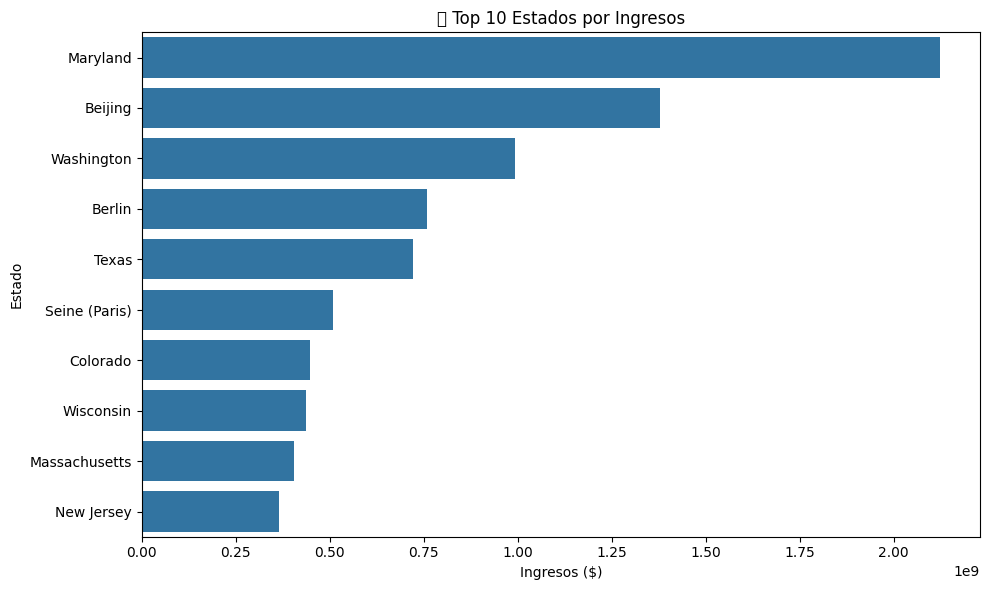

In [9]:
# Gráfico 1: Ventas por Estado (Top 10)
# Agrupar datos
ventas_estado = (
    df.groupby('STATEPROVINCENAME')['SALESAMOUNT']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=ventas_estado.values, y=ventas_estado.index)
plt.title('🏪 Top 10 Estados por Ingresos')
plt.xlabel('Ingresos ($)')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()


/tmp/ipykernel_13536/3668621292.py:7: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


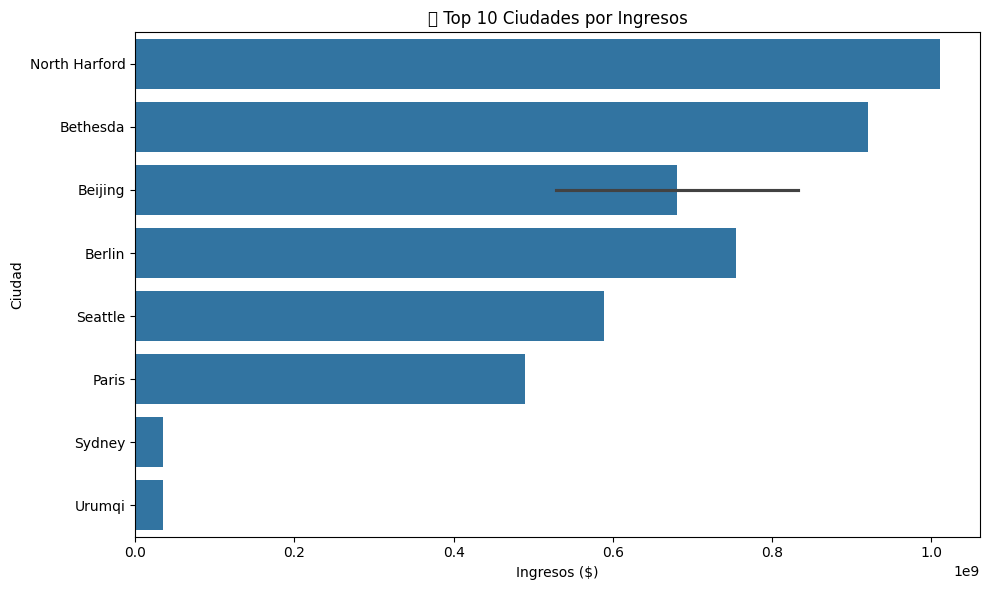

In [14]:
# Gráfico 2: Top Tiendas por Ingresos (Simple)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_stores, x='TOTAL_REVENUE', y='CITYNAME')
plt.title('🏪 Top 10 Ciudades por Ingresos')
plt.xlabel('Ingresos ($)')
plt.ylabel('Ciudad')
plt.tight_layout()
plt.show()

/tmp/ipykernel_13536/2781651652.py:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


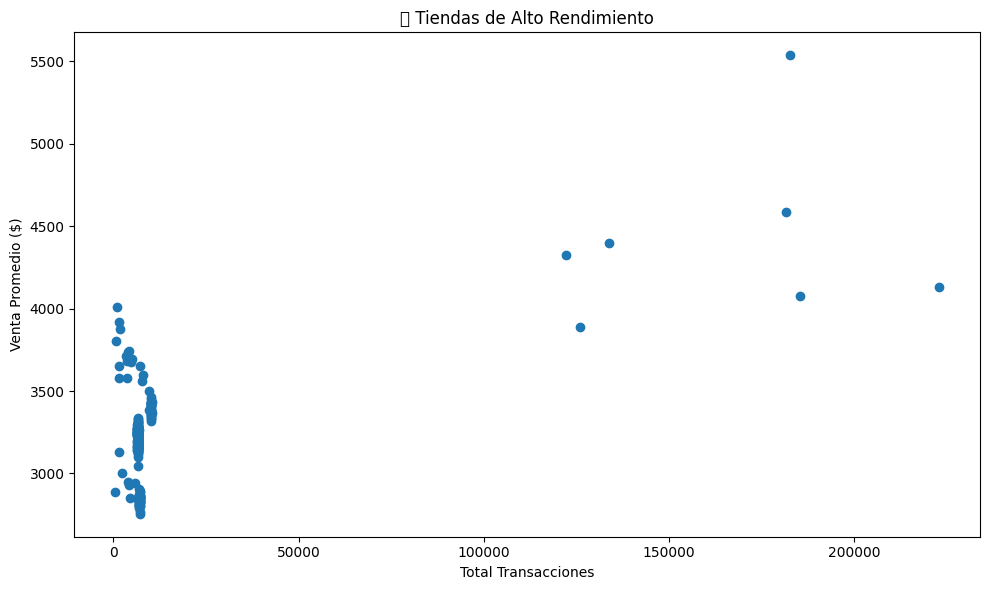

In [11]:
# Gráfico 3: Tiendas de Alto Rendimiento (Simple)

plt.figure(figsize=(10, 6))
plt.scatter(df_high_performance['TOTAL_TRANSACTIONS'], df_high_performance['AVG_SALE_AMOUNT'])
plt.title('🎯 Tiendas de Alto Rendimiento')
plt.xlabel('Total Transacciones')
plt.ylabel('Venta Promedio ($)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_13536/2561675553.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


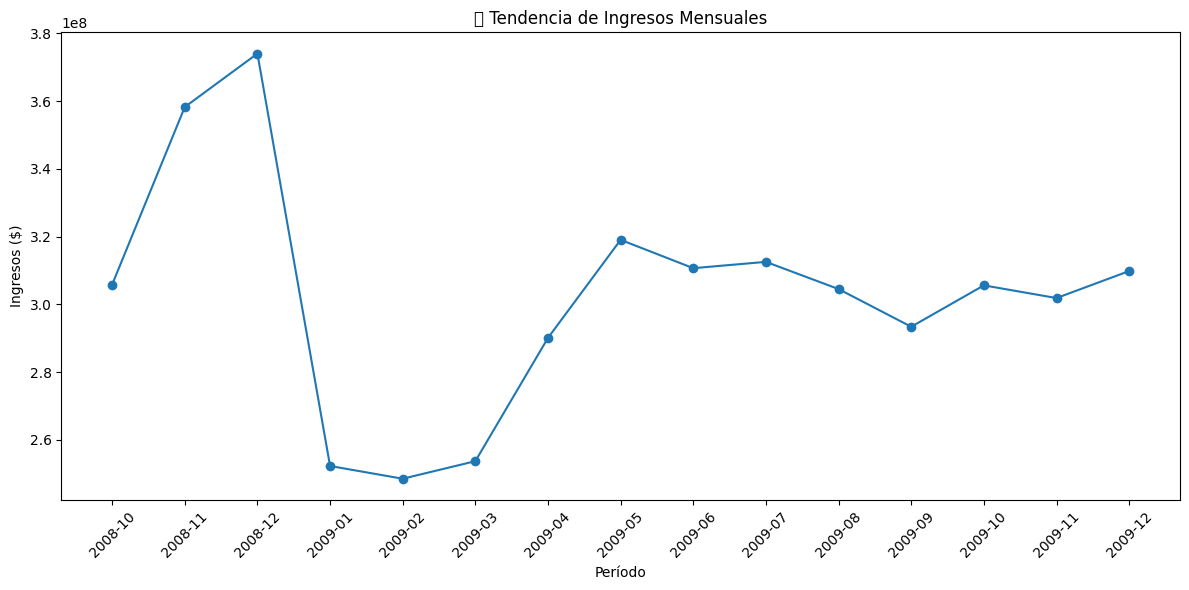

In [12]:
# Gráfico 4: Tendencia de Ventas por Tiempo (Simple)
# Limpiar datos de formato monetario
df_temp_clean = df_temporal.copy()

df_temp_clean['REVENUE'] = (
    df_temp_clean['MONTHLY_REVENUE']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Ordenar cronológicamente
df_temp_clean = df_temp_clean.sort_values(by=['SALES_YEAR', 'SALES_MONTH'])

# Gráfico de línea simple
plt.figure(figsize=(12, 6))
plt.plot(range(len(df_temp_clean)), df_temp_clean['REVENUE'], marker='o')
plt.title('📈 Tendencia de Ingresos Mensuales')
plt.xlabel('Período')
plt.ylabel('Ingresos ($)')
plt.xticks(
    range(len(df_temp_clean)),
    [f"{row['SALES_YEAR']}-{row['SALES_MONTH']:02d}" for _, row in df_temp_clean.iterrows()],
    rotation=45
)
plt.tight_layout()
plt.show()


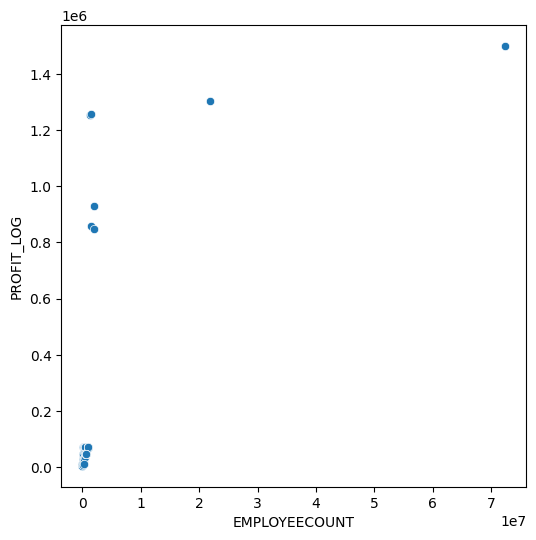

In [15]:
# Crear variable y analizar con otra
import numpy as np

df["PROFIT"] = df["SALESAMOUNT"] - df["TOTALCOST"]
df["PROFIT_LOG"] = np.log1p(df["PROFIT"])

df_EP = df.groupby('STOREKEY')[["PROFIT_LOG", "EMPLOYEECOUNT"]].sum().reset_index()

plt.figure(figsize=(6, 6))
sns.scatterplot(x="EMPLOYEECOUNT", y="PROFIT_LOG", data=df_EP)
plt.show()